# ***Rapport de prédiction du score Energy Star du bâtiment***  


## **1. Introduction**  
Dans ce rapport, je présente les résultats d'une exploration de l'ensemble de données d'analyse comparative de NYC qui mesure 60 variables liées à la consommation d'énergie de plus de 11 000 bâtiments. Le principal intérêt est le score Energy Star, qui est souvent utilisé comme mesure agrégée de l'efficacité globale
un bâtiment. Le score Energy Star est une mesure centile de la performance énergétique d’un bâtiment
calculé à partir de la consommation d'énergie autodéclarée.  
  
### 1.1 Objectifs  
  * Identifier les prédicteurs dans l'ensemble de données pour le score Energy Star  
  * Construire des modèles de régression / classification qui peuvent prédire le score Energy Star d'un bâtiment
compte tenu des données énergétiques du bâtiment  
  * Interpréter les résultats du modèle et utiliser le modèle entraîné pour déduire les scores Energy Star de
nouveaux bâtiments  





In [1]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np
# Matplotlib and seaborn for visualization
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize
import seaborn as sns
sns.set_context(font_scale=2)
# Imputing missing values
from sklearn.impute import SimpleImputer
# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
# Evaluating Models
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
# Helpers
import itertools  


# Read in cleaned data and display shape
data = pd.read_csv('/content/cleaned_data.csv')
print(data.shape)

(11747, 47)


Il y a plus de 11 000 bâtiments dans l'ensemble de données avec 60 caractéristiques énergétiques chacun. De nombreux
des colonnes contiennent une part significative de valeurs manquantes qui ont été initialement codées comme
'Pas disponible'. Dans un cahier précédent, j'ai rempli les valeurs manquantes avec nan et converti le
colonnes appropriées aux valeurs numériques pour avoir à la fin 28 vriable.

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11747 entries, 0 to 11746
Data columns (total 47 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   Order                                                       11747 non-null  object 
 1   Property Id                                                 11747 non-null  object 
 2   Property Name                                               11747 non-null  object 
 3   Parent Property Id                                          11746 non-null  object 
 4   Parent Property Name                                        11746 non-null  object 
 5   BBL - 10 digits                                             11746 non-null  object 
 6   NYC Borough, Block and Lot (BBL) self-reported              11735 non-null  object 
 7   NYC Building Identification Number (BIN)                    11583 non-null  object 
 

## **Data Exploration**  
Comme nous sommes principalement concernés par le score Energy Star, le premier graphique à faire montre la distribution
de cette mesure pour tous les bâtiments de l'ensemble de données qui ont un score

### **2.1 Distribution du Scores Energy Star**

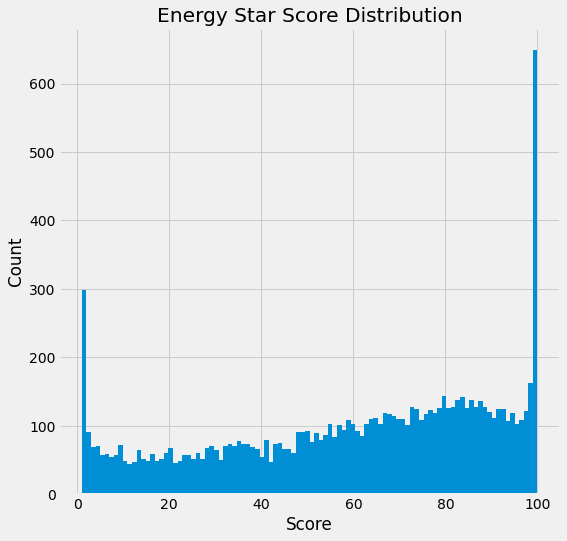

In [5]:
plt.style.use('fivethirtyeight')
figsize(8, 8)
# Histogram of Energy Star Scores with 100 bins
plt.hist(data['ENERGY STAR Score'].dropna(), bins = 100);
plt.title('Energy Star Score Distribution');
plt.xlabel('Score'); plt.ylabel('Count');

#### **2.1.1 Problème potentiel avec les scores Energy Star**  
  
  Le score Energy Star est une mesure basée sur la consommation d'énergie autodéclarée d'un bâtiment qui est censée représenter le centile d'énergie
classement de performance d'un bâtiment. Compte tenu de la distribution ci-dessus, soit cet ensemble de données a une partie élevée
d'immeubles extraordinairement efficaces, ou la mesure n'est pas objective. Environ 7% des bâtiments
ont un score d'exactement 100, mais nous nous attendrions à ce que la distribution soit uniforme entre les scores
car il s'agit d'une mesure centile.
Contrairement au score Energy Star, l'intensité d'utilisation de l'énergie (EUI) est basée sur l'énergie réelle
utiliser tel que déterminé par l'utilitaire. Le calcul est simple: prenez l'énergie annuelle totale
utiliser (en kBtu) et diviser par la superficie en pieds carrés du bâtiment. L'EUI est destiné à normalisé
des comparaisons de consommation d'énergie entre des bâtiments du même type de bâtiment. Cette mesure est probablement plus
objectif car il utilise la consommation réelle. Dans le graphique ci-dessous, nous pouvons voir que le
la distribution de l'intensité d'utilisation d'énergie est normale, ce que nous attendons d'une
variable.

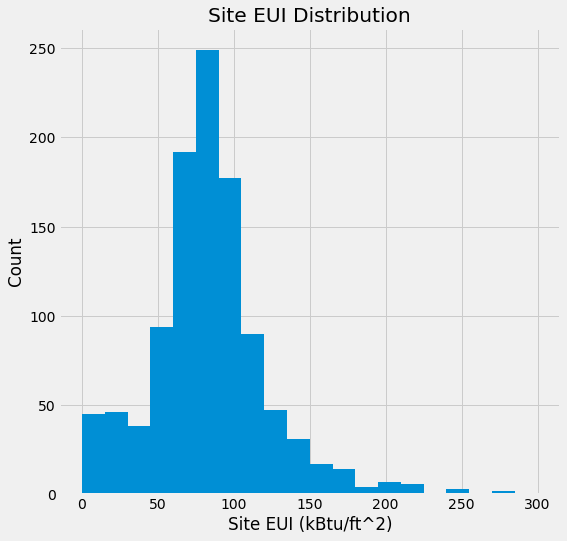

In [9]:
figsize(8, 8)
# Histograms of Site EUI across all buildings in dataset
plt.hist(data['Weather Normalized Site EUI (kBtu/ft²)'].dropna(),
bins = 20, range = (0, 300));
plt.title('Site EUI Distribution'); plt.xlabel('Site EUI (kBtu/ft^2)');
plt.ylabel('Count');

Même s'il y a des problèmes avec le score Energy Star, cette analyse se concentrera sur cette mesure.
Cependant, des recherches supplémentaires devraient être menées sur ces scores pour déterminer pourquoi
la distribution est inhabituelle. Étant donné la distribution suspecte de cette valeur, il serait intéressant de
trouver une meilleure mesure globale de la performance énergétique d’un bâtiment. Nous pouvons encore essayer de prédire le
Score Energy Star, mais ce n'est pas parce que nous pouvons prédire une valeur qu'elle est utile!

### **Score Energy Star par type de bâtiment**  
Afin de déterminer si certains types de bâtiments ont tendance à obtenir un score meilleur ou pire sur l'Energy Star
Score, nous pouvons tracer la distribution des scores Energy Star par type de bâtiment. Voici une densité
graphique montrant la distribution des scores pour les types de bâtiments avec plus de 80 mesures dans le
Les données.  
  
Les limites x du graphique de densité du noyau s'étendent au-delà de la plage des scores réels en raison de la
méthode d'estimation de la densité du noyau utilisée pour faire la distribution de densité de probabilité. L'actuel
les valeurs d'un graphique de densité peuvent être difficiles à interpréter, et il est plus instructif de se concentrer sur
distribution / forme de la figure.

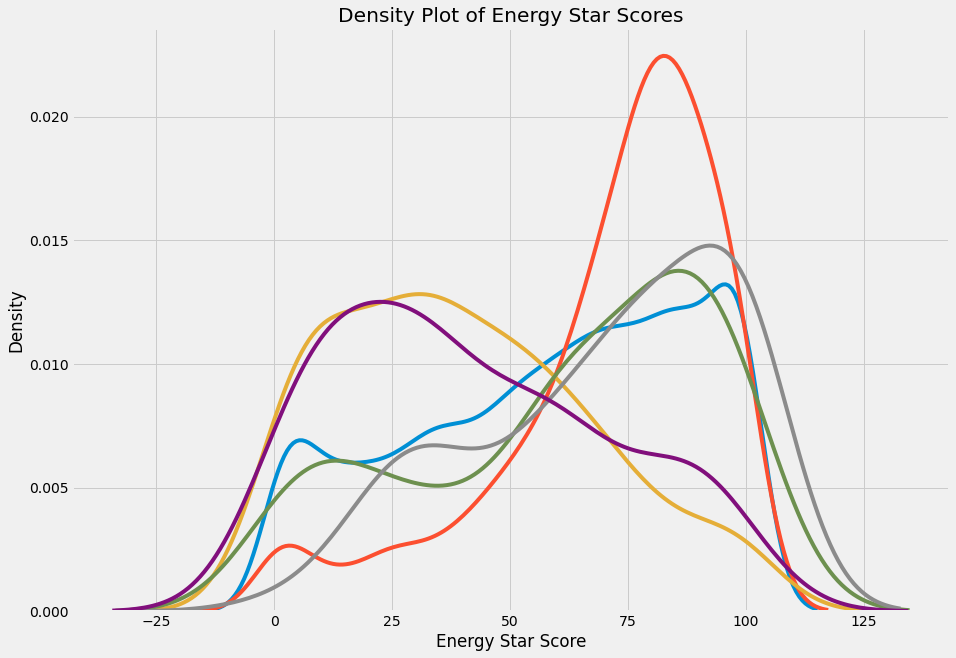

In [11]:
# Create a list of buildings with more than 80 measurements
types = data.dropna(subset=['ENERGY STAR Score'])
types = types['Primary Property Type - Self Selected'].value_counts()
types = list(types[types.values > 80].index)
figsize(14, 10)
# Plot each building
for b_type in types:
# Select the building type
    subset = data[data['Primary Property Type - Self Selected'] == b_type]
# Density plot of Energy Star scores
    sns.kdeplot(subset['ENERGY STAR Score'].dropna(), label = b_type);

plt.xlabel('Energy Star Score'); plt.ylabel('Density');
plt.title('Density Plot of Energy Star Scores');


Cela nous donne notre première conclusion: les immeubles de bureaux ont tendance à avoir des scores Energy Star beaucoup plus élevés
que les hôtels et les communautés de soins pour personnes âgées. Résidences et entrepôts non réfrigérés également
ont des scores plus élevés alors que les logements multifamiliaux ont une distribution bimodale des scores similaire à la
distribution globale. Il serait utile de voir si cela vaut pour un échantillon de plus grande taille et d'obtenir
plus de données pour comprendre pourquoi certains types de bâtiments ont tendance à faire mieux.  
Dans le carnet d'exploratio, j'ai identifié qu'il y avait une corrélation négative entre le site
EUI et le score Energy Star. Nous pouvons tracer l'EUI du site par type de bâtiment pour voir s'il existe également un
différence de site EUI entre les types de bâtiments.

### **Site EUI par type de bâtiment**  


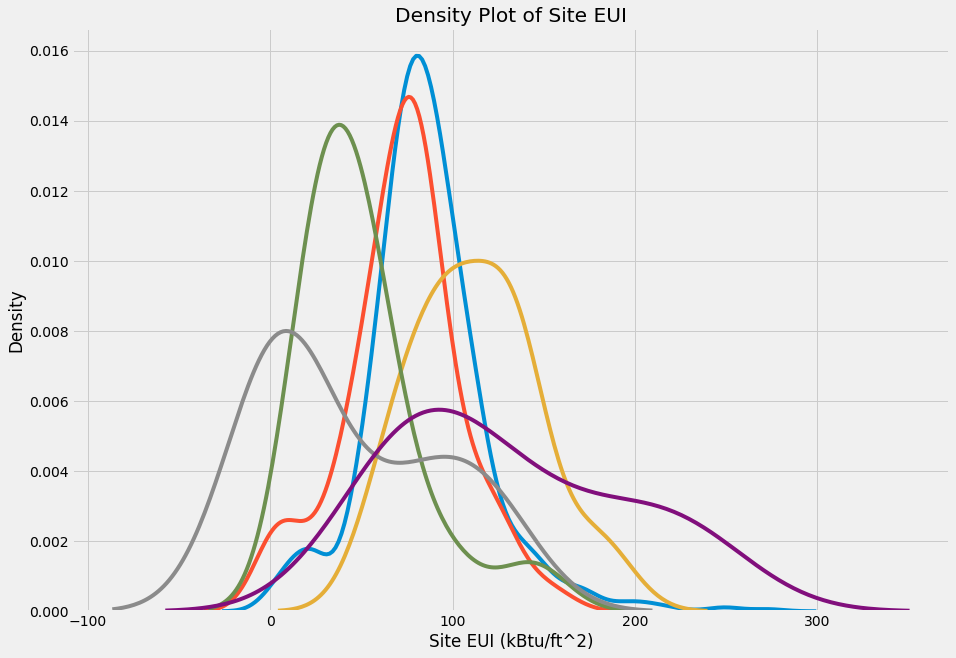

In [13]:
figsize(14, 10)
# Plot the site EUI density plot for each building type
for b_type in types:
# Remove outliers before plotting
    subset = data[(data['Weather Normalized Site EUI (kBtu/ft²)'] < 300) &
    (data['Primary Property Type - Self Selected'] == b_type)]
# Plot the site EUI on a density plot
    sns.kdeplot(subset['Weather Normalized Site EUI (kBtu/ft²)'].dropna(),
    label = b_type);


plt.xlabel('Site EUI (kBtu/ft^2)'); plt.ylabel('Density');
plt.title('Density Plot of Site EUI');

Ce graphique nous fournit une autre conclusion: il semble y avoir une corrélation négative entre
l'EU du site et le score Energy Star basé sur la comparaison des deux distributions entre
types de bâtiments. Les types de bâtiments avec des IUE de site plus faibles ont tendance à avoir des scores Energy Star plus élevés. Le
plus l’intensité de la consommation d’énergie (qui correspond à la consommation d’énergie / à la superficie) est "mauvaise" l’efficacité énergétique du bâtiment
performance. Nous pouvons visualiser la relation entre le score Energy Star et le site
EUI dans un nuage de points.

### **Score Energy Star par rapport à l'EUI du site**

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


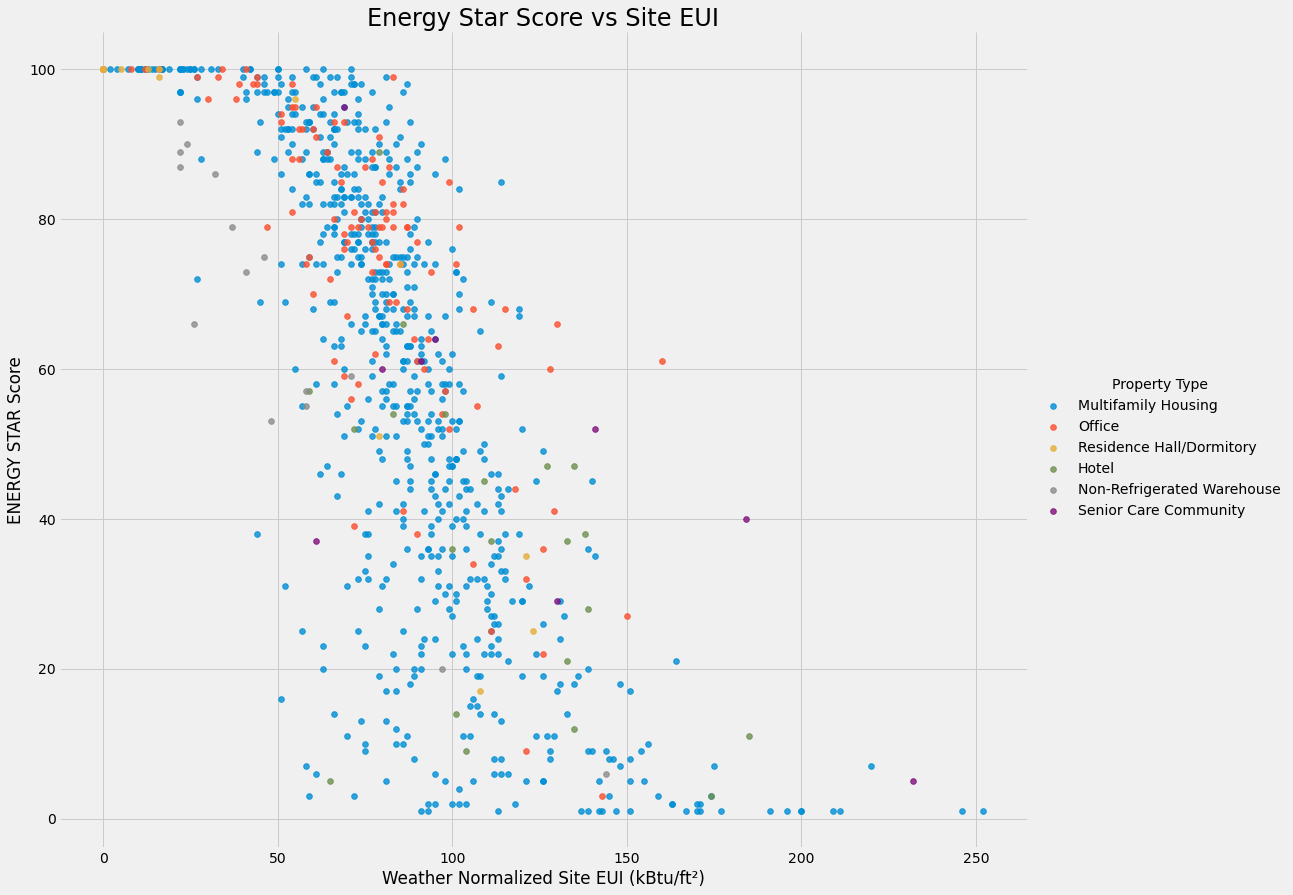

In [19]:
figsize(14, 10)
# Subset to the buildings with most measurements and remove outliers
subset = data[(data['Weather Normalized Site EUI (kBtu/ft²)'] < 300) &
(data['Primary Property Type - Self Selected'].isin(types))]
# Drop the buildings without a value
subset = subset.dropna(subset=['ENERGY STAR Score',
'Weather Normalized Site EUI (kBtu/ft²)'])
subset = subset.rename(columns={'Primary Property Type - Self Selected': 'Property Type'}) 
# Linear Plot of Energy Star Score vs EUI
sns.lmplot('Weather Normalized Site EUI (kBtu/ft²)', 'ENERGY STAR Score',data = subset, hue = 'Property Type',scatter_kws={'alpha': 0.8, 's': 32}, fit_reg=False, size = 12, aspect = 1.2);
plt.title('Energy Star Score vs Site EUI', size = 24);

Le graphique montre la relation négative attendue entre le score Energy Star et l'EU du site.
Cette relation semble être valable pour tous les types de bâtiments. Pour quantifier la relation, nous pouvons
calculer le coefficient de corrélation de Pearson entre les deux variables. C'est une mesure de
corrélation linéaire qui montre à la fois la force et la direction de la relation. Nous regarderons
au coefficient de corrélation entre les scores Energy Star et plusieurs mesures.

### **Corrélations linéaires avec le score Energy Star**

In [22]:
# List of Variables to find correlation coefficients
features = ['Primary Property Type - Self Selected',
            'Weather Normalized Site EUI (kBtu/ft²)',
         'Weather Normalized Site Electricity Intensity (kWh/ft²)',
         'Largest Property Use Type - Gross Floor Area (ft²)',
         'Natural Gas Use (kBtu)',
         'ENERGY STAR Score']

subset = data[features].dropna()
subset = subset[subset['Primary Property Type - Self Selected'].isin(types)]
# Rename the columns
subset.columns = ['Property Type', 'Site EUI',
'Electricity Intensity', 'Floor Area',
'Natural Gas', 'Energy Star Score']
# Remove outliers
subset = subset[subset['Site EUI'] < 300]
# Group by the building type and calculate correlations
corrs = pd.DataFrame(subset.groupby('Property Type').corr())
corrs = pd.DataFrame(corrs['Energy Star Score'])
# Format the dataframe for display
corrs = corrs.reset_index()
corrs.columns = ['Property Type', 'Variable', 'Correlation with Score']
corrs = corrs[corrs['Variable'] != 'Energy Star Score']
corrs
            

,Property Type,Variable,Correlation with Score
0,Multifamily Housing,Site EUI,-0.598840
1,Multifamily Housing,Electricity Intensity,-0.856830
2,Multifamily Housing,Floor Area,0.117585
3,Multifamily Housing,Natural Gas,-0.306769
5,Office,Site EUI,-1.000000
6,Office,Electricity Intensity,-1.000000
7,Office,Floor Area,1.000000
8,Office,Natural Gas,-1.000000
10,Senior Care Community,Site EUI,NaN
11,Senior Care Community,Electricity Intensity,NaN


Cela montre la corrélation entre le score Energy Star et trois mesures différentes par bâtiment
taper. Pour tous les bâtiments, nous constatons les relations suivantes: le score Energy Star est fortement négatif
en corrélation avec l'intensité électrique et l'IUE du site. La force de la corrélation du gaz naturel
dépend de l'ensemble de données, mais l'utilisation du gaz naturel a tendance à être corrélée négativement avec l'Energy Star
Score aussi. La relation entre la surface de plancher et le score Energy Star est faible pour tous les bâtiments
les types.

### **Supprimer les entités colinéaires**  
Avant de créer un modèle d'apprentissage automatique, nous souhaitons supprimer les fonctionnalités très colinéaires
les uns avec les autres (pas avec le score Energy Star). L'objectif est de déterminer s'il y a
variables indépendantes qui sont prédictives du score Energy Star, nous ne voulons donc pas utiliser
plusieurs variables colinéaires dans notre modèle. Par exemple, Site EUI et Weather Normalized
Les IUE du site sont très fortement corrélées (près de 1,0) et nous n'avons donc besoin d'inclure que l'un des
ces mesures dans notre modèle.  
  
Une méthode simple pour supprimer des entités colinéaires consiste à calculer le coefficient de corrélation entre
chaque paire de variables et supprimez celles dont la magnitude est supérieure à un seuil spécifié.
Cette procédure est effectuée ici, en utilisant un seuil de 0,5 pour la grandeur du coefficient de corrélation.

In [26]:
# Remove correlations from the dataframe that are above corr_val
def corr_df(x, corr_val):
   # Dont want to remove correlations between Energy Star Score
   y = x['ENERGY STAR Score']
   x = x.drop(columns = ['ENERGY STAR Score'])
   # Matrix of all correlations
   corr_matrix = x.corr()
   iters = range(len(corr_matrix.columns) - 1)
   drop_cols = []
  # Iterate through all correlations
   for i in iters:
       for j in range(i):
           item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
           col = item.columns
           row = item.index
           val = abs(item.values)
           # If correlation is above the threshold, add to list to remove
           if val >= corr_val:
               drop_cols.append(col.values[0])
    # Remove collinear variables
   drops = set(drop_cols)
   x = x.drop(columns = drops)
   x = x.drop(columns = ['Site EUI (kBtu/ft²)'])
   # Make sure to add the label back in to the data
   x['ENERGY STAR Score'] = y
   return x


In [27]:
new_data = corr_df(data, corr_val = 0.5)
print('Old Data Shape:', data.shape)
print('New Data Shape with correlated features removed', new_data.shape)

Old Data Shape: (11747, 47)
New Data Shape with correlated features removed (11747, 33)


In [30]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11747 entries, 0 to 11746
Data columns (total 33 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   Order                                                   11747 non-null  object 
 1   Property Id                                             11747 non-null  object 
 2   Property Name                                           11747 non-null  object 
 3   Parent Property Id                                      11746 non-null  object 
 4   Parent Property Name                                    11746 non-null  object 
 5   BBL - 10 digits                                         11746 non-null  object 
 6   NYC Borough, Block and Lot (BBL) self-reported          11735 non-null  object 
 7   NYC Building Identification Number (BIN)                11583 non-null  object 
 8   Address 1 (self-reported)           

La procédure a supprimé 14 colonnes hautement colinéaires des données. La prochaine étape consiste à déterminer
si nous pouvons créer des modèles d'apprentissage automatique qui peuvent utiliser ces fonctionnalités pour prédire la cible,
Score Energy Star.

## **3. Approche Machine Learning**  
L'objectif est de prédire le score Energy Star d'un bâtiment compte tenu des variables disponibles
les données. Tout d'abord, nous séparerons les bâtiments qui ont un score et ceux qui n'en ont pas pour plus tard
inférence. Parmi les bâtiments avec un score énergétique, nous utiliserons 75% pour la formation du modèle et 25%
pour évaluer notre modèle. Nous allons essayer deux méthodes différentes:  
  1. Régression: prédire la valeur numérique du score Energy Star  
    * Métriques: Erreur absolue moyenne, l'écart moyen entre les prédictions et vrai
valeurs et Rˆ2, le pourcentage de variation de la réponse expliquée par le modèle  
  2. Classification: divisez les bâtiments en 5 groupes en fonction des intervalles de score Energy Star de
20 points. Prédisez la classe pour un bâtiment.  
    * Métriques: précision, f1_score (la moyenne harmonique de la précision et du rappel) et la confusion
matrice  
  
Nous pourrions également essayer de regrouper les bâtiments, mais pour l'instant nous nous en tiendrons à la machine supervisée
méthodes d'apprentissage. Les méthodes non supervisées constitueraient une piste intéressante pour une étude plus approfondie.

### **3.1 Prétraitement des fonctionnalités**  
Pour préparer les données pour l'apprentissage automatique, nous utiliserons quelques étapes de prétraitement standard:  
  
1. Sous-ensemble de colonnes numériques et 3 colonnes catégorielles. Je souhaite avant tout me concentrer sur l'utilisation
les valeurs numériques pour prédire le score, mais j'inclurai également des colonnes catégorielles comprenant
le type de bâtiment car nous l'avons vu est lié au score.  
2. Encodage à chaud des variables catégorielles.  
3. Diviser en ensembles de formation et de test (après avoir extrait les bâtiments sans score). Nous serons
utilisant 75% de formation et 25% de tests.  
4. Imputer les valeurs manquantes. Il existe de nombreuses méthodes d'imputation, mais j'utiliserai la
imputation médiane simple. Nous devons former l'imputer uniquement sur les données d'entraînement
et effectuer des transformations à la fois des données d'entraînement et des données de test.  
5. Renvoie les valeurs pour l'apprentissage et le test du modèle.

## **Régression des scores Energy Star**  
**Prétraitement de la régression**

In [33]:
#Takes in a dataframe with observations for each building
# Returns all the data needed for training and testing a regression model
def train_test_reg(df):
    # Select the numerical columns
    X = df.select_dtypes('number')
    # Add the selected categorical columns
    X['Largest Property Use Type'] = df['Largest Property Use Type']
    X['Metered Areas (Energy)'] = df['Metered Areas (Energy)']
    X['DOF Benchmarking Submission Status'] = df['DOF Benchmarking Submission Status']
    # One-hot encoding of categorical values
    X = pd.get_dummies(X)
    # Extract the buildings with no score
    missing_scores = X[X['ENERGY STAR Score'].isnull()]
    # Drop the missing scores from the data
    X = X.dropna(subset = ['ENERGY STAR Score'])
    # Remove the labels from the features
    y = X['ENERGY STAR Score' ]
    X = X.drop(columns = ['ENERGY STAR Score'])
    missing_scores = missing_scores.drop(columns = ['ENERGY STAR Score'])
    # Feature names will be used for later interpretation
    feature_names = list(X.columns)
    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size = 0.25,
    random_state = 42)
    # Impute missing values using a median strategy
    imputer = SimpleImputer(strategy = 'median')
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)
    missing_scores = imputer.transform(missing_scores)
    # Return all data
    return X_train, X_test, y_train, y_test, missing_scores, feature_names


In [34]:
X_train, X_test, y_train, y_test, missing_scores, feature_names = train_test_reg(new_data)
print('Training Data Shape:', X_train.shape)
print('Testing Data Shape:', X_test.shape)

Training Data Shape: (7230, 68)
Testing Data Shape: (2411, 68)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

Nous formerons le modèle avec plus de 7000 bâtiments en utilisant 68 fonctionnalités (encodage à chaud
augmente considérablement le nombre de fonctionnalités car il crée une fonctionnalité pour chaque valeur d'un
variables catégorielles). Les données de formation et de test ont le même nombre de fonctionnalités qui est un
bon contrôle de santé mentale!

### **Établir une base de référence de régression**  
Avant de mettre en œuvre un modèle d'apprentissage automatique, nous devons calculer une ligne de base de bon sens.
Si notre modèle ne peut pas battre cette marque, alors l'apprentissage automatique peut ne pas être approprié pour la tâche. Pour
tâches de régression, une simple référence consiste à prédire la valeur moyenne de la cible dans les données d'entraînement pour
tous les exemples de tests.

In [35]:
# Baseline is mean of training label
baseline = np.mean(y_train)
base_error = np.mean(abs(baseline - y_test))
print('Baseline Error: {:0.4f}.'.format(base_error))

Baseline Error: 25.4431.


Si notre modèle ne peut pas battre une erreur moyenne de 26, alors nous devrons repenser notre approche

### **Régression Linéaire**  
Une régression linéaire est extrêmement simple et produit des résultats explicables. C'est bien
méthode pour commencer dans l'apprentissage automatique car nous pouvons interpréter les résultats. Cependant, si le
problème n'est pas linéaire, alors notre modèle ne sera pas très utile.

In [37]:
# Create and train the model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
# Make predictions and evaluate
lin_pred = lin_reg.predict(X_test)

print('Linear Regression Error: {:0.4f}.'.format(np.mean(abs(lin_pred - y_test))))

Linear Regression Error: 24.6818.


Ce n'est pas très bien! Nous passerons à des modèles d'apprentissage automatique plus sérieux. Le problème
au fur et à mesure que nous augmentons la complexité, alors que notre précision augmentera, l'interprétabilité
diminuer.

### **Random Forest**  
Ensuite, j'implémente une régression de forêt aléatoire. La forêt aléatoire est quelque peu interprétable car
il renvoie les importances des fonctionnalités que nous pouvons utiliser pour comparer les variables les plus utiles pour
faire des prédictions. La forêt aléatoire est généralement très précise et fonctionne bien sur non-linéaire
problèmes avec de nombreuses fonctionnalités car il effectue une sélection implicite de fonctionnalités.  
'utilise toutes les valeurs par défaut de scikit-learn pour la forêt aléatoire sauf que j'ai augmenté le nombre de
arbres de la forêt de 10 à 200. En général, les hyperparamètres par défaut fonctionnent bien mais peuvent être
optimisé à l'aide de la validation croisée.

In [38]:
# Create and train random forest
rf_reg = RandomForestRegressor(n_estimators=200, n_jobs=-1)
rf_reg.fit(X_train, y_train)
# Make predicitons and evaluate
rf_reg_pred = rf_reg.predict(X_test)
print('Random Forest Error: {:0.4f}.'.format(np.mean(abs(rf_reg_pred - y_test))))

Random Forest Error: 24.4384.


L'erreur est nettement inférieure à la ligne de base, nous pouvons donc admettre que l'utilisation de l'apprentissage de maching
prédire le score Energy Star est possible compte tenu de l'ensemble de données. L'erreur de test montre que notre
modèle peut prédire le score Energy Star à moins de 10 points de la valeur réelle en moyenne.
Comme autre évaluation de notre modèle, nous pouvons calculer le score rˆ2 entre les prédictions
et les vraies valeurs. Cela nous donne une indication du rapport de variance expliqué par le modèle.
Une valeur plus élevée (le maximum est 1) indique que notre modèle est mieux en mesure d'expliquer la relation
entre les entrées et les sorties.

In [39]:
print('Random Forest R^2: {:0.4f}.'.format(np.corrcoef(rf_reg_pred, y_test)[0][1]))

Random Forest R^2: 0.2533.


In [41]:
from sklearn.ensemble import GradientBoostingRegressor

# Create the model
gradient_boosted = GradientBoostingRegressor()

# Fit the model on the training data
gradient_boosted.fit(X_train, y_train)

# Make predictions on the test data
predictions = gradient_boosted.predict(X_test)

# Evaluate the model
mae = np.mean(abs(predictions - y_test))

print('Gradient Boosted Performance on the test set: MAE = %0.4f' % mae)

Gradient Boosted Performance on the test set: MAE = 23.7354


In [42]:
print('Gradient Boosted R^2: {:0.4f}.'.format(np.corrcoef(predictions, y_test)[0][1]))

Gradient Boosted R^2: 0.2993.


L'interprétation de la valeur Rˆ2 est que notre modèle explique 30% de la variance de l'énergie
Score d'étoile. Le reste de la variation est dû au bruit ou à des variables latentes (cachées) que nous n'avons pas
accès aux données.

### **Interpréter les résultats de la régression**  
Examinons d'abord la distribution des scores prévus et des scores réels.

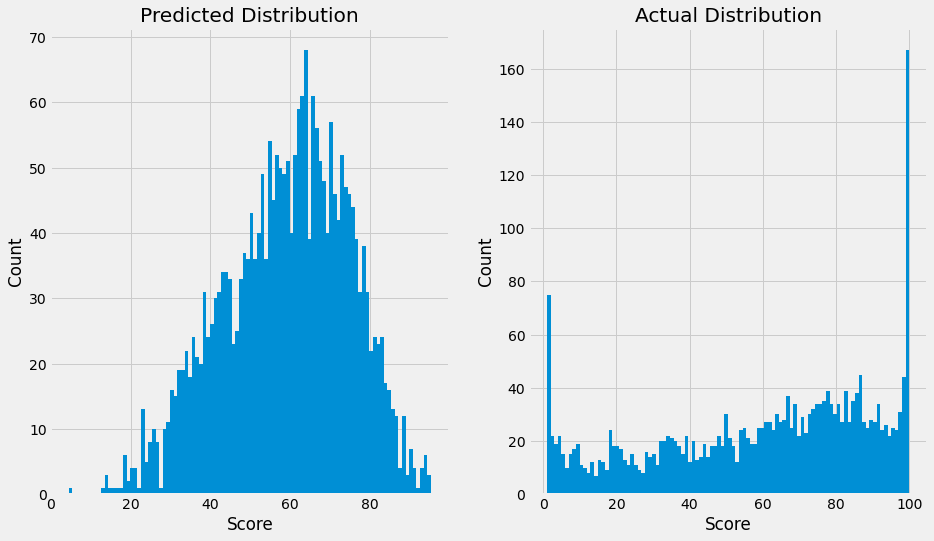

In [43]:
figsize(14, 8)
# Plot predictions
ax = plt.subplot(121)
ax.hist(rf_reg_pred, bins = 100)
ax.set_xlabel('Score'); ax.set_ylabel('Count');
ax.set_title('Predicted Distribution')
# Plot true values
ax2 = plt.subplot(122)
ax2.hist(y_test, bins = 100)
ax2.set_xlabel('Score'); ax2.set_ylabel('Count');
ax2.set_title('Actual Distribution');

le modèle peut prédire le mode des scores à 100, ne semble pas être en mesure de prédire le faible
scores très bien. La correction de ce déséquilibre pourrait être un domaine de travail futur. Nous pourrions également essayer différents
modèles pour optimiser l'erreur, mais pour l'instant, nous avons montré que l'apprentissage automatique se prête au
problème.

#### **Scores prévus de nouveaux bâtiments**  
Nous pouvons maintenant utiliser le modèle pour générer de nouvelles prédictions pour les bâtiments avec des scores manquants.

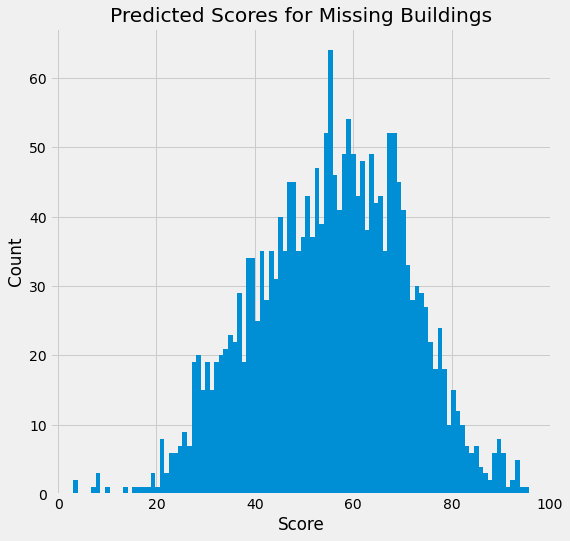

In [45]:
#Predict for the buildings missing energy star scores
missing_preds = rf_reg.predict(missing_scores)
figsize(8, 8)
# Distribution of predicted scores
plt.hist(missing_preds, bins = 100);
plt.xlabel('Score'); plt.ylabel('Count');
plt.title('Predicted Scores for Missing Buildings');

Notre modèle peut maintenant faire une prédiction pour tout nouveau bâtiment tant qu'il a les mesures
enregistré dans les données originales. Nous pouvons utiliser ce modèle entraîné pour déduire le score et nous savons que
notre estimation doit être à moins de 10 points de la valeur réelle.

#### **Interpret Feature Importances**  
La principale façon dont nous pouvons comprendre le modèle de forêt aléatoire est de regarder quelles caractéristiques
il considère le plus important. Les valeurs absolues des importances des fonctionnalités ne sont pas aussi cruciales que
le classement relatif des variables. Celles-ci nous indiquent quelles variables sont les plus utiles pour prédire la
Score Energy Star.

In [48]:
def interpret_features(feature_list, importances):
    # Make a dataframe of features and importances
    feature_df = pd.DataFrame({'feature': feature_list,'importance': importances})
    # Sort the features from most to least important
    feature_df = feature_df.sort_values('importance', ascending = False)
    figsize(8, 8)
    # Plot the most important features
    plt.bar(feature_df[feature_df['importance'] > 0.01]['feature'],
    feature_df[feature_df['importance'] > 0.01]['importance'])
    # Plot formatting
    plt.xticks(rotation = 90)
    plt.xlabel('feature'); plt.ylabel('importance');
    plt.title('Top Feature Importances')
    plt.show();

    return feature_df

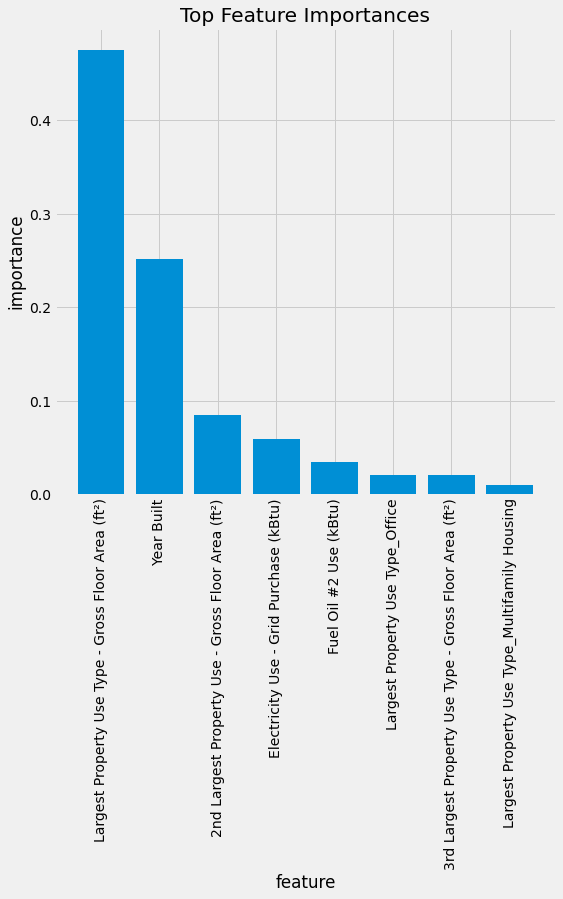

In [49]:
reg_features = interpret_features(feature_names, rf_reg.feature_importances_)

In [50]:
reg_features.head(10)

,feature,importance
0,Largest Property Use Type - Gross Floor Area (...,0.474923
3,Year Built,0.251227
1,2nd Largest Property Use - Gross Floor Area (ft²),0.084807
5,Electricity Use - Grid Purchase (kBtu),0.059227
4,Fuel Oil #2 Use (kBtu),0.034977
30,Largest Property Use Type_Office,0.021009
2,3rd Largest Property Use Type - Gross Floor Ar...,0.020565
27,Largest Property Use Type_Multifamily Housing,0.010553
19,Largest Property Use Type_Hotel,0.009959
29,Largest Property Use Type_Non-Refrigerated War...,0.006287


Selon le modèle de forêt aléatoire, les caractéristiques les plus importantes pour prédire l'énergie
Le score d'étoile d'un bâtiment est l'EU du site, l'intensité électrique, le type d'utilisation de la propriété, le
Utilisation du gaz naturel et zone. Celles-ci sont en ligne avec les variables que nous avons vues sont les plus
corrélé avec le score Energy Star.
Examinons la relation entre le score Energy Star, l'EU du site, l'électricité
intensité, la consommation de gaz naturel et la superficie du bâtiment. Dans l'exploration, nous avons remarqué que
ces relations sont plus proches de linéaires lorsque la transformation logarithmique de la variable est prise. On le fera
appliquez cette transformation et examinez les relations qui en résultent.

In [54]:
#List of Features to Plot
#features = ['Largest Property Use Type - Gross Floor Area (ft²)','ENERGY STAR Score']
#subset = new_data[features].dropna()
# Rename the columns
#subset.columns = ['Site EUI', 'Electricity Intensity', 'Floor Area', 'Natural Gas', 'Score']
# Remove outliers and problem values
#subset = subset[subset['Site EUI'] < 300]
# Log Transforms
#subset['log Site EUI'] = np.log(subset['Site EUI'])
#subset['log Electricity Intensity'] = np.log(subset['Electricity Intensity'])

## **Classification des scores Energy Star**  
Comme exercice supplémentaire, nous pouvons voir s'il est possible de placer des bâtiments dans des classes en fonction de leur
scores Energy Star.  
  
  
**Prétraitement de la classification**

In [69]:
# Function to generate a training and testing dataset for classification
# Codes the energy star score in 5 unique classes
def train_test_clf(df):
    # Select numeric columns
    X = df.select_dtypes('number')
# Add in specific categorical columns
    X['Largest Property Use Type'] = df['Largest Property Use Type']
    X['Metered Areas (Energy)'] = df['Metered Areas (Energy)']
    X['DOF Benchmarking Submission Status'] = df['DOF Benchmarking Submission Status' ] 
    # One Hot Encoding of Categorical Variables
    X = pd.get_dummies(X)
# Save the buildings with missing scores
    missing_scores = X[X['ENERGY STAR Score'].isnull()]
    X = X.dropna(subset = ['ENERGY STAR Score'])
# Assign a grade based on energy star score
    X['grade'] = pd.cut(X['ENERGY STAR Score'], bins = range(0, 101, 20))
    y = X['grade']
# Drop labels from training data
    X = X.drop(columns = [ 'ENERGY STAR Score'])
    missing_scores = missing_scores.drop(columns = [ 'ENERGY STAR Score'])
    feature_names = list(X.columns)
# Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25) 
                                                        # Impute the missing values using a median strategy
    imputer = SimpleImputer(strategy = 'median')
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)
    missing_scores = imputer.transform(missing_scores)
    return X_train, X_test, y_train, y_test, missing_scores, feature_names

In [70]:
X_train, X_test, y_train, y_test, missing_scores, feature_names = train_test_clf(new_data)
# Look at value counts of grades
pd.Series(y_train).value_counts()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

TypeError: ignored

Le «grade» le plus courant pour un bâtiment est un A et le moins commun est un F.
vers des scores d'étoiles énergétiques plus élevés est à nouveau visible (l'auto-déclaration ne semble pas
stratégie objective).

### **Random Forest Classifier**

In [71]:
# Create and train the classifier
rf_clf = RandomForestClassifier(n_estimators=200)
rf_clf.fit(X_train, y_train)
# Make predictions
rf_clf_pred = rf_clf.predict(X_test)

### **Interpret Classification Results**  
Il existe de nombreuses métriques à utiliser pour la classification. Ici, nous utiliserons la précision, le score f1 et le
matrice de confusion. Nous utiliserons le paramètre de moyenne pondérée du score f1 pour tenir compte du
déséquilibres de classe. La matrice de confusion nous permet de voir quelles erreurs notre classifieur fait.

In [75]:
# Function to plot a confusion matrix
# Includes the numbers of each classification on the plot
def plot_confusion_matrix(cm, classes,
normalize=False,
title='Confusion matrix',
cmap=plt.cm.Reds):
# Normalize the counts
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #Plot the confusion matrix as an image
    plt.figure(figsize(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 22)
    # Tick marks show the labels
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    # Add the numbers to the plot
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
          plt.text(j, i, format(cm[i, j], fmt),
          horizontalalignment="center", size = 18,
          color="white" if cm[i, j] > thresh else "black")

    # Formatting
    plt.tight_layout()
    plt.xticks(size = 18)
    plt.yticks(size = 18)
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)


# Function the evalute classifications from a model
def evaluate_classifications(true, predictions):
# Metrics for classifications
    accuracy = np.mean(true == predictions)
    f1_value = f1_score(true, predictions, average='weighted')
    cm = confusion_matrix(true, predictions)
    print('Accuracy: {:0.2f}.'.format(accuracy))
    print('F1 score: {:0.2f}.'.format(f1_value))
    plot_confusion_matrix(cm, classes = sorted(set(true)))

Accuracy: 0.03.
F1 score: 0.03.


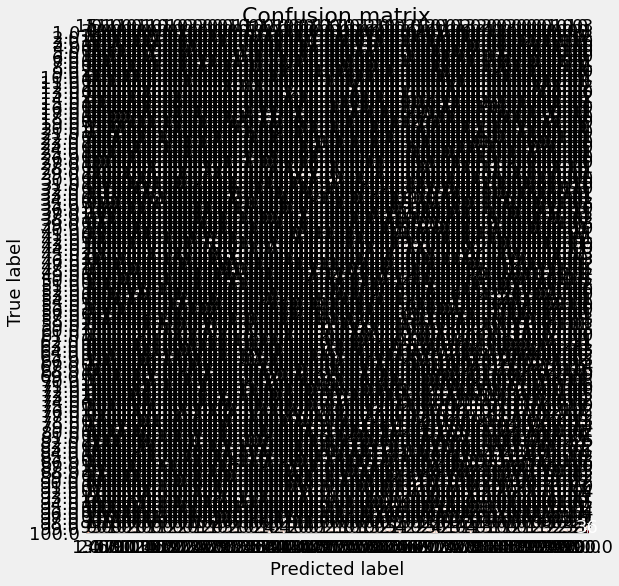

In [76]:
evaluate_classifications(y_test, rf_clf_pred)

La précision est une métrique simple et elle montre que notre modèle peut choisir correctement parmi
les cinq classes 60% du temps. La matrice de confusion est utile car elle montre le modèle
des erreurs. Les erreurs les plus courantes consistent à prédire un "A" alors que le véritable libellé était un "B", et
prédire un "B" alors que la vraie étiquette était un "C". Le classificateur aléatoire de forêt semble très bien fonctionner
et peut déduire avec précision le score Energy Star d'un bâtiment s'il est fourni avec les données du bâtiment.

#### **Classifications prévues des nouvelles données**  
Le classificateur peut également être utilisé pour attribuer des notes aux bâtiments pour lesquels il manquait une note. Nous
n'ont pas les vraies valeurs pour ces bâtiments, mais on peut au moins regarder la répartition des
prédictions.

In [78]:
missing_classes = rf_clf.predict(missing_scores)
pd.Series(missing_classes).value_counts()

100.0    415
1.0      164
2.0       60
93.0      52
75.0      45
        ... 
95.0       6
28.0       5
35.0       5
12.0       4
21.0       1
Length: 100, dtype: int64

Tout nouveau bâtiment peut désormais être classé par le modèle tant qu'il est pourvu du
Les données. Nous pouvons être confiants dans les prédictions du modèle comme le montre la haute performance
sur les données de test.

## **Conclusions**  
Nous avons tenté de répondre à la question: Pouvons-nous construire un modèle pour prédire le score Energy Star d'un
bâtiment et quelles variables nous fournissent le plus d'informations sur le score?
Compte tenu de l'exploration de ce cahier, je conclus que oui, nous pouvons créer un modèle pour
déduire le score Energy Star d'un bâtiment et nous avons déterminé que l'intensité d'utilisation d'énergie du site,
l'intensité électrique, la surface de plancher, la consommation de gaz naturel et le type de bâtiment sont
les mesures les plus utiles pour déterminer le score Energy Star.
Les points saillants du rapport sont:  
   
1. Les scores Energy Star sont asymétriques élevés avec un maximum mondial disproportionné à 100 et un
maximum secondaire à 1.
2. Les bureaux, les résidences universitaires et les entrepôts non réfrigérés ont des scores Energy Star plus élevés que
les communautés de soins pour personnes âgées et les hôtels avec des dizaines de logements multifamiliaux se situant entre les deux.
3. L'intensité de la consommation d'énergie du site, l'intensité de l'électricité et la consommation de gaz naturel sont toutes
corrélé négativement avec le score Energy Star.
4. Un régresseur forestier aléatoire formé sur les données d'entraînement a pu obtenir une moyenne absolue
erreur de 10 points sur un ensemble de tests de résistance, ce qui était nettement meilleur que la ligne de base
mesure.
5. S'il est fourni avec des données pour un nouveau bâtiment, un modèle formé peut en déduire avec précision l'énergie
Score d'étoile.

Ce rapport a également identifié les domaines de suivi. Il s'agit notamment de trouver une mesure objective
de la performance énergétique globale du bâtiment et déterminer pourquoi les distributions du score Energy Star
varient selon les types de bâtiments. C'est tout pour le moment!